In [1]:
!pip install tensorflow opencv-python matplotlib albumentations

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import os
import time
import cv2
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

In [3]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img, channels=3)
    return img

In [16]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)      

In [4]:
img = cv2.imread(os.path.join('data','train', 'images','1-0_137_2.jpg'))

In [5]:
with open(os.path.join('data', 'train', 'labels', '1-0_137_2.json'), 'r') as f:
    label = json.load(f)

In [6]:
label[0]['points']

[[24, 29], [33, 42]]

In [7]:
img.shape

(64, 64, 3)

In [8]:
coords = [0,0,0,0]
coords[0] = label[0]['points'][0][0]
coords[1] = label[0]['points'][0][1]
coords[2] = label[0]['points'][1][0]
coords[3] = label[0]['points'][1][1]

In [9]:
coords

[24, 29, 33, 42]

In [10]:
coords = list(np.divide(coords, [img.shape[1],img.shape[0],img.shape[1],img.shape[0]]))

In [11]:
coords

[0.375, 0.453125, 0.515625, 0.65625]

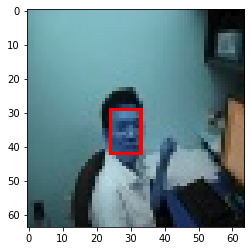

In [12]:
cv2.rectangle(img, 
              tuple(np.multiply(coords[:2], [img.shape[1],img.shape[0]]).astype(int)),
              tuple(np.multiply(coords[2:], [img.shape[1],img.shape[0]]).astype(int)), 
                    (255,0,0), 1)

plt.imshow(img)

In [13]:
train_images = tf.data.Dataset.list_files('data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: x/255)

In [14]:
test_images = tf.data.Dataset.list_files('data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: x/255)

In [15]:
val_images = tf.data.Dataset.list_files('data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: x/255)

In [16]:
train_images.as_numpy_iterator().next()

array([[[0.8980392 , 0.90588236, 0.9019608 ],
        [0.9137255 , 0.92156863, 0.91764706],
        [0.9098039 , 0.91764706, 0.9137255 ],
        ...,
        [0.33333334, 0.3372549 , 0.31764707],
        [0.33333334, 0.32156864, 0.29411766],
        [0.3019608 , 0.2901961 , 0.25490198]],

       [[0.9019608 , 0.9098039 , 0.90588236],
        [0.9137255 , 0.92156863, 0.91764706],
        [0.9137255 , 0.92156863, 0.91764706],
        ...,
        [0.3529412 , 0.34901962, 0.33333334],
        [0.36078432, 0.36078432, 0.32941177],
        [0.42352942, 0.4117647 , 0.3764706 ]],

       [[0.9098039 , 0.91764706, 0.9137255 ],
        [0.91764706, 0.9254902 , 0.92156863],
        [0.91764706, 0.9254902 , 0.92156863],
        ...,
        [0.9529412 , 0.9490196 , 0.93333334],
        [0.95686275, 0.95686275, 0.9254902 ],
        [0.93333334, 0.93333334, 0.89411765]],

       ...,

       [[0.17254902, 0.16862746, 0.2       ],
        [0.16862746, 0.16470589, 0.19607843],
        [0.16862746, 0

In [17]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    if label[0]['label'] == "face":
        label[0]['label'] = 1
    else:
        label[0]['label'] = 0
    
    coords = [0,0,0,0]
    coords[0] = label[0]['points'][0][0]/64
    coords[1] = label[0]['points'][0][1]/64
    coords[2] = label[0]['points'][1][0]/64
    coords[3] = label[0]['points'][1][1]/64
    label[0]['points'] = coords
    return [label[0]['label']], label[0]['points']

In [18]:
train_labels = tf.data.Dataset.list_files('data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [19]:
test_labels = tf.data.Dataset.list_files('data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [20]:
val_labels = tf.data.Dataset.list_files('data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [21]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.2344, 0.25  , 0.6875, 0.828 ], dtype=float16))

In [22]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(3313, 3313, 1000, 1000, 650, 650)

In [34]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(3500)
train = train.batch(8)
train = train.prefetch(4)

In [35]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1200)
test = test.batch(8)
test = test.prefetch(4)

In [36]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(800)
val = val.batch(8)
val = val.prefetch(4)

In [37]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.4688, 0.2344, 0.625 , 0.4688],
        [0.2344, 0.2031, 0.797 , 0.922 ],
        [0.2812, 0.1406, 0.6875, 0.625 ],
        [0.5312, 0.25  , 0.7656, 0.6094],
        [0.4219, 0.375 , 0.6406, 0.6562],
        [0.4062, 0.2344, 0.578 , 0.4688],
        [0.3438, 0.1719, 0.6562, 0.5312],
        [0.1719, 0.1562, 0.703 , 0.75  ]], dtype=float16))

In [38]:
data_samples = train.as_numpy_iterator()

In [39]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


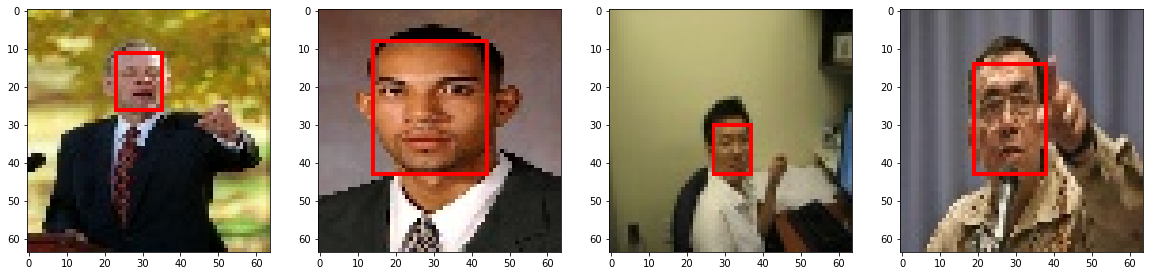

In [40]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [64,64]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [64,64]).astype(int)), 
                        (255,0,0), 1)

    ax[idx].imshow(sample_image)

In [41]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D, MaxPool2D
from tensorflow.keras.applications import VGG16

In [42]:
vgg = VGG16(include_top=False)

In [43]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [44]:
def build_model(): 
    input_layer = Input(shape=(64,64,3))
    
    vgg = VGG16(include_top=False, pooling='max')(input_layer)

    # Classification Model  
    class1 = Dense(2048, activation='relu')(vgg)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    regress1 = Dense(2048, activation='relu')(vgg)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

In [45]:
def build_model1(): 
    input_layer = Input(shape=(64,64,3))
    
    vgg = VGG16(include_top=False)(input_layer)
    
    class0 = Conv2D(filters=512,kernel_size=(3,3),padding="same", activation="relu")(vgg)
    maxclass0 = GlobalMaxPooling2D()(class0)

    # Classification Model  
    class1 = Dense(2048, activation='relu')(maxclass0)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    regress1 = Dense(2048, activation='relu')(maxclass0)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

In [54]:
facetracker = build_model()

In [55]:
facetracker1 = build_model1()

In [57]:
facetracker.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 vgg16 (Functional)             (None, 512)          14714688    ['input_8[0][0]']                
                                                                                                  
 dense_12 (Dense)               (None, 2048)         1050624     ['vgg16[0][0]']                  
                                                                                                  
 dense_14 (Dense)               (None, 2048)         1050624     ['vgg16[0][0]']                  
                                                                                            

In [58]:
facetracker1.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_10[0][0]']               
                                512)                                                              
                                                                                                  
 conv2d_3 (Conv2D)              (None, 2, 2, 512)    2359808     ['vgg16[0][0]']                  
                                                                                                  
 global_max_pooling2d_4 (Global  (None, 512)         0           ['conv2d_3[0][0]']         

In [60]:
X, y = train.as_numpy_iterator().next()

In [61]:
X.shape

(8, 64, 64, 3)

In [62]:
classes, coords = facetracker.predict(X)

In [63]:
classes, coords

(array([[0.3513034 ],
        [0.521335  ],
        [0.47963813],
        [0.45338732],
        [0.4792109 ],
        [0.4552318 ],
        [0.37661272],
        [0.38580048]], dtype=float32),
 array([[0.4301042 , 0.45024806, 0.6236964 , 0.67794305],
        [0.55691975, 0.47782946, 0.5780022 , 0.53985816],
        [0.40385538, 0.48503578, 0.5875551 , 0.5369386 ],
        [0.5011826 , 0.5101684 , 0.5731099 , 0.54134816],
        [0.50669885, 0.46097705, 0.6816991 , 0.6133195 ],
        [0.45674446, 0.43248633, 0.6087774 , 0.5135812 ],
        [0.4831073 , 0.47321537, 0.5719069 , 0.51466733],
        [0.40749818, 0.43924624, 0.62031   , 0.57145345]], dtype=float32))

In [64]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [65]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

In [66]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [67]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

In [68]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=1.4560057>

In [69]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.8343417>

In [70]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=1.4560057>

In [71]:
class FaceTracker(Model): 
    def __init__(self, facetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = facetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            total_loss = batch_localizationloss+batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [72]:
model = FaceTracker(facetracker)

In [73]:
model1 = FaceTracker(facetracker1)

In [75]:
model.compile(opt, classloss, regressloss)

In [76]:
model1.compile(opt, classloss, regressloss)

In [78]:
logdir='logs'

In [79]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [80]:
logdir1='logs1'

In [81]:
tensorboard_callback1 = tf.keras.callbacks.TensorBoard(log_dir=logdir1)

In [84]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10
415/415 [==============================] - 358s 841ms/step - total_loss: 0.1987 - class_loss: 0.0070 - regress_loss: 0.1917 - val_total_loss: 0.0181 - val_class_loss: 5.5853e-05 - val_regress_loss: 0.0180
Epoch 2/10
415/415 [==============================] - 325s 778ms/step - total_loss: 0.0556 - class_loss: 6.3318e-05 - regress_loss: 0.0556 - val_total_loss: 0.0241 - val_class_loss: 8.6427e-07 - val_regress_loss: 0.0241
Epoch 3/10
415/415 [==============================] - 330s 790ms/step - total_loss: 0.0323 - class_loss: 1.7549e-05 - regress_loss: 0.0323 - val_total_loss: 0.0119 - val_class_loss: 5.9605e-08 - val_regress_loss: 0.0119
Epoch 4/10
415/415 [==============================] - 326s 779ms/step - total_loss: 0.0195 - class_loss: 9.0851e-06 - regress_loss: 0.0195 - val_total_loss: 0.0053 - val_class_loss: 0.0000e+00 - val_regress_loss: 0.0053
Epoch 5/10
415/415 [==============================] - 327s 783ms/step - total_loss: 0.0146 - class_loss: 4.8074e-06 - regres

In [85]:
hist1 = model1.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback1])

Epoch 1/10
415/415 [==============================] - 408s 972ms/step - total_loss: 0.2638 - class_loss: 0.0053 - regress_loss: 0.2585 - val_total_loss: 0.0291 - val_class_loss: 3.2992e-05 - val_regress_loss: 0.0291
Epoch 2/10
415/415 [==============================] - 440s 1s/step - total_loss: 0.0807 - class_loss: 1.9697e-05 - regress_loss: 0.0806 - val_total_loss: 0.0076 - val_class_loss: 8.3447e-07 - val_regress_loss: 0.0076
Epoch 3/10
415/415 [==============================] - 440s 1s/step - total_loss: 0.0492 - class_loss: 7.6055e-06 - regress_loss: 0.0492 - val_total_loss: 0.0210 - val_class_loss: 0.0000e+00 - val_regress_loss: 0.0210
Epoch 4/10
415/415 [==============================] - 405s 970ms/step - total_loss: 0.0340 - class_loss: 4.2374e-06 - regress_loss: 0.0340 - val_total_loss: 0.0040 - val_class_loss: 0.0000e+00 - val_regress_loss: 0.0040
Epoch 5/10
415/415 [==============================] - 412s 987ms/step - total_loss: 0.0243 - class_loss: 2.5838e-06 - regress_loss

In [88]:
hist.history

{'total_loss': [0.003838852746412158,
  0.0006161108613014221,
  0.00017325991939287633,
  0.0010652535129338503,
  0.0002475231303833425,
  0.000522069982253015,
  0.002269844291731715,
  0.00033199653262272477,
  0.0006184903322719038,
  0.000988232553936541],
 'class_loss': [5.155934559297748e-05,
  -0.0,
  1.7881409348774469e-06,
  -0.0,
  -0.0,
  -0.0,
  -0.0,
  -0.0,
  5.960466182841628e-07,
  -0.0],
 'regress_loss': [0.003787293331697583,
  0.0006161108613014221,
  0.0001714717800496146,
  0.0010652535129338503,
  0.0002475231303833425,
  0.000522069982253015,
  0.002269844291731715,
  0.00033199653262272477,
  0.0006178942858241498,
  0.000988232553936541],
 'val_total_loss': [0.018050577491521835,
  0.024055689573287964,
  0.01191906537860632,
  0.005267313681542873,
  0.0031393528915941715,
  0.0010034118313342333,
  0.0030691465362906456,
  0.0033049029298126698,
  0.0008592422236688435,
  0.010976959951221943],
 'val_class_loss': [5.585263716056943e-05,
  8.642680313641904e

In [89]:
hist1.history

{'total_loss': [0.00827577244490385,
  0.005213473923504353,
  0.001985088922083378,
  0.0040679615922272205,
  9.670918370829895e-05,
  0.0004962214734405279,
  0.000277134618954733,
  0.00106962607242167,
  0.00022773795353714377,
  0.0012144175125285983],
 'class_loss': [5.66245716981939e-06,
  7.152560215217818e-07,
  7.391003236989491e-06,
  -0.0,
  1.6927862816373818e-05,
  -0.0,
  -0.0,
  7.152560215217818e-07,
  -0.0,
  -0.0],
 'regress_loss': [0.008270110003650188,
  0.005212758667767048,
  0.0019776979461312294,
  0.0040679615922272205,
  7.978131907293573e-05,
  0.0004962214734405279,
  0.000277134618954733,
  0.0010689108166843653,
  0.00022773795353714377,
  0.0012144175125285983],
 'val_total_loss': [0.02908673696219921,
  0.007616644259542227,
  0.020983047783374786,
  0.003978542517870665,
  0.004250904079526663,
  0.04355601966381073,
  0.0020664522890001535,
  0.004208258353173733,
  0.003977303393185139,
  0.017400462180376053],
 'val_class_loss': [3.2991953048622236

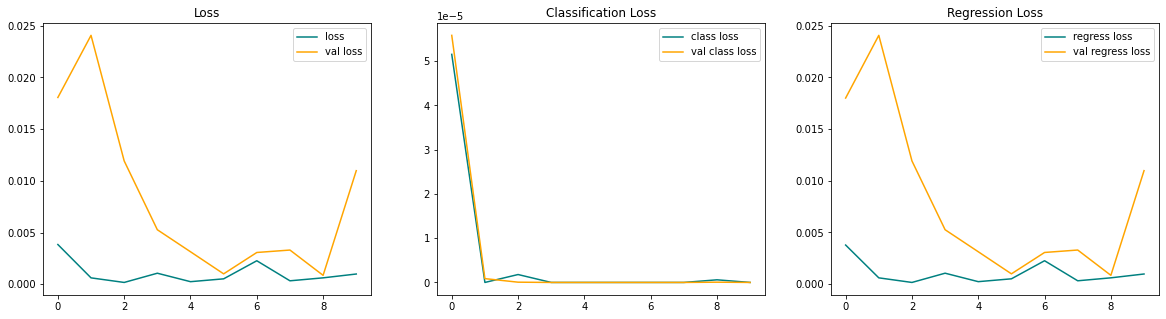

In [91]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

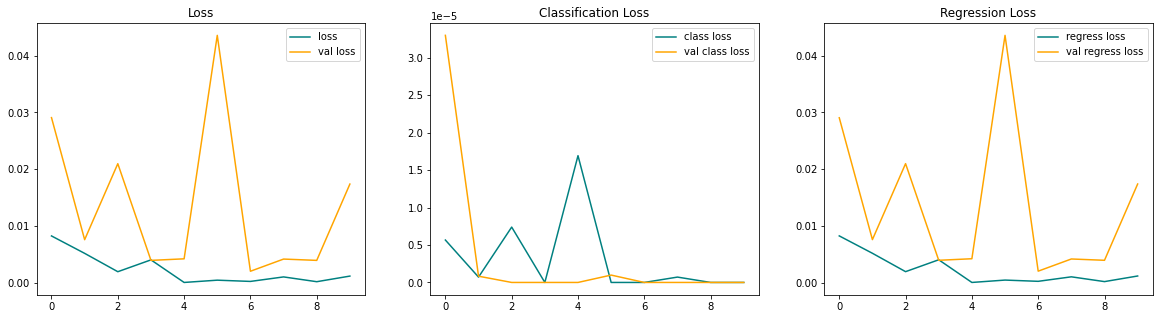

In [92]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist1.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist1.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist1.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist1.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist1.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist1.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

In [7]:
test_data = testt.as_numpy_iterator()

In [14]:
test_sample = test_data.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


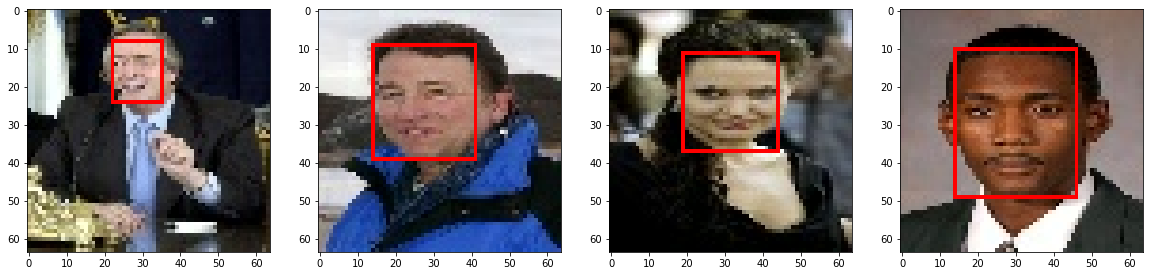

In [15]:
yhat = facetracker.predict(test_sample[0])

fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [sample_image.shape[1],sample_image.shape[0]]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [sample_image.shape[1],sample_image.shape[0]]).astype(int)), 
                            (255,0,0), 1)
    
    ax[idx].imshow(sample_image)

In [1]:
from tensorflow.keras.models import load_model

In [104]:
facetracker.save('facetracker.h5')

In [112]:
np.savez('hist', **hist.history)

In [113]:
np.savez('hist1', **hist1.history)

In [3]:
res = np.load('hist.npz')

In [5]:
res['class_loss']

array([ 5.15593456e-05, -0.00000000e+00,  1.78814093e-06, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        5.96046618e-07, -0.00000000e+00])

In [2]:
facetracker = load_model('facetracker.h5')

In [121]:
testt = tf.data.Dataset.zip((test_images, test_labels))

In [122]:
tf.data.experimental.save(testt, 'file.zip')

In [5]:
testt = tf.data.experimental.load('file.zip')

In [6]:
testt = testt.shuffle(1200)
testt = testt.batch(8)
testt = testt.prefetch(4)

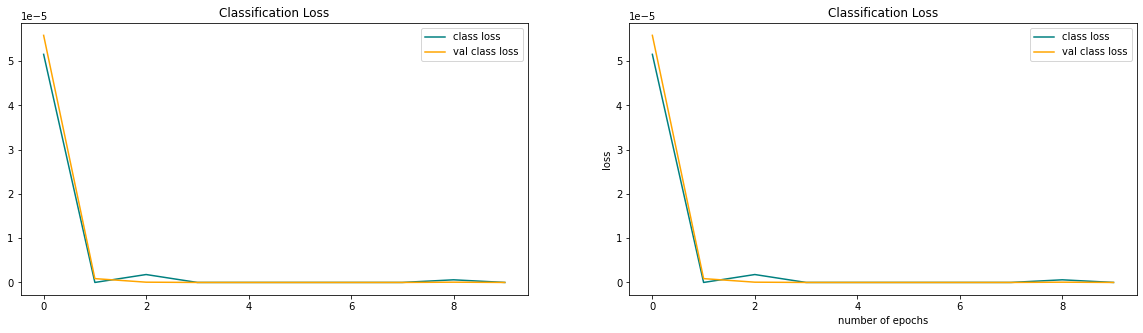

In [10]:
fig, ax = plt.subplots(ncols=2, figsize=(20,5))

plt.xlabel('number of epochs')
plt.ylabel('loss')

ax[0].plot(res['class_loss'], color='teal', label='class loss')
ax[0].plot(res['val_class_loss'], color='orange', label='val class loss')
ax[0].title.set_text('Classification Loss')
# plt.xlabel('number of epochs')
# plt.ylabel('loss')
ax[0].legend()

ax[1].plot(res['class_loss'], color='teal', label='class loss')
ax[1].plot(res['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
# plt.xlabel('number of epochs')
# plt.ylabel('loss')
ax[1].legend()


plt.show()

In [18]:
res1 = np.load('hist1.npz')

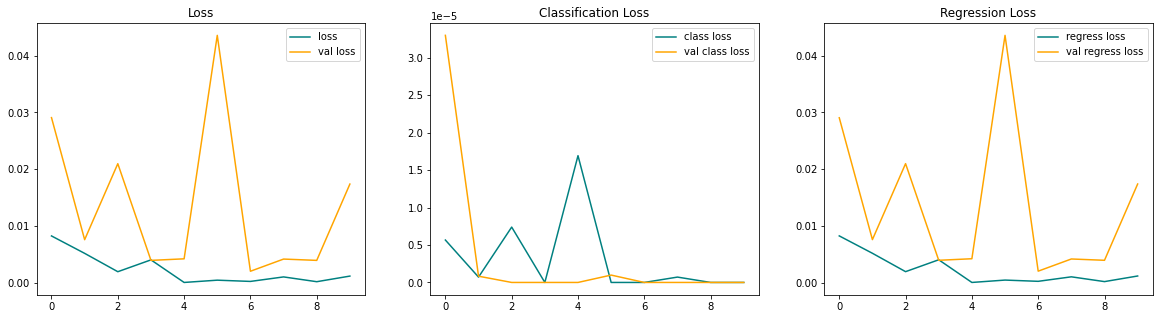

In [19]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(res1['total_loss'], color='teal', label='loss')
ax[0].plot(res1['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(res1['class_loss'], color='teal', label='class loss')
ax[1].plot(res1['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(res1['regress_loss'], color='teal', label='regress loss')
ax[2].plot(res1['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()